In [1]:
import pip


try:
    __import__('fbprophet')
except ImportError:
    pip.main(['install', 'fbprophet']) 
try:
    __import__('keras')
except ImportError:
    pip.main(['install', 'keras']) 

try:
    __import__('lightgbm')
except ImportError:
    pip.main(['install', 'lightgbm'])     
try:
    __import__('pyspark.ml')
except ImportError:
    pip.main(['install', 'pyspark'])     

Using TensorFlow backend.
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/keras/legacy/interfaces.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  wrapper._legacy_support_signature = inspect.getargspec(func)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.s

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import lightgbm as lgb

from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
!wget https://raw.githubusercontent.com/patrick-s-upc/sales-forecast/master/train.csv
!wget https://raw.githubusercontent.com/patrick-s-upc/sales-forecast/master/test.csv

--2018-08-30 11:20:57--  https://raw.githubusercontent.com/patrick-s-upc/sales-forecast/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17333449 (17M) [text/plain]
Saving to: ‘train.csv.18’

100%[======================================>] 17,333,449  52.6MB/s   in 0.3s   

2018-08-30 11:20:58 (52.6 MB/s) - ‘train.csv.18’ saved [17333449/17333449]

--2018-08-30 11:20:58--  https://raw.githubusercontent.com/patrick-s-upc/sales-forecast/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975309 (952K) [text/plain]
Saving to: ‘test.csv.17’

100%[======================================>] 97

In [4]:
!ls

a2_m1.json	       submission.csv		test.csv.16   train.csv.14
a2_m1.json.zip	       submission-lgb2.csv	test.csv.17   train.csv.15
a2_m1.json.zip.base64  submission-lgb.csv	test.csv.2    train.csv.16
a2_m2.json	       submission-lstm.csv	test.csv.3    train.csv.17
a2_m2.json.zip	       submission-prophet2.csv	test.csv.4    train.csv.18
a2_m2.json.zip.base64  submission-prophet.csv	test.csv.5    train.csv.2
a2_m3.json	       submission-xgb2.csv	test.csv.6    train.csv.3
a2_m3.json.zip	       submission-xgb.csv	test.csv.7    train.csv.4
a2_m3.json.zip.base64  test.csv			test.csv.8    train.csv.5
a2_m4.json	       test.csv.1		test.csv.9    train.csv.6
a2_m4.json.zip	       test.csv.10		train.csv     train.csv.7
a2_m4.json.zip.base64  test.csv.11		train.csv.1   train.csv.8
__pycache__	       test.csv.12		train.csv.10  train.csv.9
rklib.py	       test.csv.13		train.csv.11  train.txt
scratch_space	       test.csv.14		train.csv.12
submission-arima.csv   test.csv.15		train.csv.13


In [5]:
df_train = pd.read_csv("train.csv")
df_train_date = pd.read_csv("train.csv",parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv("test.csv")
df_test_date = pd.read_csv("test.csv",parse_dates=['date'], index_col=['date'])

In [6]:
# Sales distribution across the train data
df_sales = df_train.copy(deep=True)
print("dims",df_sales.shape)
df_sales['sales_bins'] = pd.cut(df_sales.sales, [0, 50, 100, 150, 200, 250])
print('Max sale:', df_sales.sales.max())
print('Min sale:', df_sales.sales.min())
print('Avg sale:', df_sales.sales.mean())
print()

dims (913000, 4)
Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005



In [7]:
# Total number of data points
total_points = pd.value_counts(df_sales.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(df_sales.sales_bins).apply(lambda s: (s/total_points)*100))

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

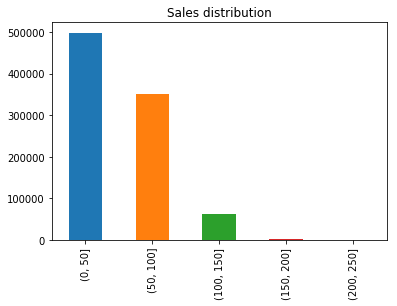

In [8]:
pd.value_counts(df_sales.sales_bins).plot(kind='bar', title='Sales distribution');

-92% of sales are less than 100 items a day.
-Max, min and average sales are 231, 0 and 52.25 respectively.
#note without bin analysis

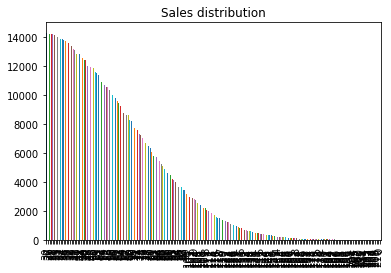

In [9]:
#distribution of item sales count a day
pd.value_counts(df_train.sales).plot(kind='bar', title='Sales distribution');

In [10]:
#right skewed data
list(df_train)

['date', 'store', 'item', 'sales']

In [11]:
# stores average item count a day for each item
df_store = df_train.copy()
df_sales_pivoted = pd.pivot_table(df_store, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
# Pivoted dataframe
display(df_sales_pivoted)

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                     ...                 \
item          7          8          9          10    ...             41   
store                                                ...                  
1      52.783680  69.472070  46.504929  66.354326    ...      20.002738   
2      75.058598  99.090361  65.478094  94.097481    ...      28.069551   
3      66.647864  87.517525  58.486857  83.387733    ...      24.989047   
4      61.625411  80.819825  54.043812  77.047645    ...      23.168127   
5      44.535597  58.565717  38.837349  55.509858    ...      16.830778   
6      44.599124  58.385542  39.460022  55.565170    ...      16.607338   
7      40.709748  53.723987  35.901972  51.156627    ...      15.471522   
8      71.730559  94.461117  63.193319  89.818182    ...      27.036145   
9      61.812158  81.287514  54.105696  77.105148    ...      23.191128   
10     65.807777  86.176889  57.886637  82.232202    ...      24.654984   

                                                                          \
item          42         43         44          45         46         47   
store                                                                      
1      33.105696  46.242607  26.594195   72.720701  52.845016  19.814348   
2      47.368018  65.785323  37.785871  103.381161  75.219606  28.187842   
3      41.797371  58.197700  33.386090   91.851041  66.748083  25.120482   
4      38.539978  54.018620  30.952355   84.687295  61.420044  23.114458   
5      27.730559  39.163198  22.415115   61.427163  44.734940  16.699343   
6      27.893209  39.034502  22.322563   61.142935  44.539978  16.708653   
7      25.435926  35.426068  20.446331   55.905805  40.828587  15.479189   
8      45.144031  62.980285  36.194414   98.941402  72.004929  27.150055   
9      38.643483  54.152793  30.968237   85.093647  62.010953  23.003286   
10     41.222892  57.942497  32.916758   90.690581  66.046550  24.755750   

                                        
item          48         49         50  
store                                   
1      46.546002  26.461665  59.342826  
2      66.028478  37.711939  84.622125  
3      58.700986  33.259584  74.958379  
4      53.765608  30.840635  68.921687  
5      39.281490  22.371851  50.319277  
6      39.052574  22.181271  50.516429  
7      35.624315  20.406353  45.823658  
8      62.737130  36.035049  80.972070  
9      53.976999  31.052574  69.308324  
10     57.814896  33.032311  74.037240  

[10 rows x 50 columns]

In [12]:
# Let us calculate the average sales of all the items by each store
df_sales_across_store = df_sales_pivoted.copy()
df_sales_across_store['avg_sales'] = df_sales_across_store.apply(lambda r: r.mean(), axis=1)

In [13]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = df_sales_across_store.avg_sales.values,
    mode='markers',
    marker=dict(
        size = df_sales_across_store.avg_sales.values,
        color = df_sales_across_store.avg_sales.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = df_sales_across_store.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        tick0=2,
        title= 'Stores',
        ticklen= 11,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

ID 2 and ID 8 store have the highest average sales

While ID 5,6,7 have the lowest

In [14]:
#calculate the average sales of each of the item across all the stores
df_sales_across_item = df_sales_pivoted.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
df_sales_across_item.loc[11] = df_sales_across_item.apply(lambda r: r.mean(), axis=0)
# Note the 11th index row, which is the average sale of each of the item across all the stores
#display(sales_across_item_df.loc[11:])
df_avg_sales_per_item_across_stores = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(df_sales_across_item.loc[11:].values[0])], columns=['item', 'avg_sale'])
# And finally, sort by avg sale
df_avg_sales_per_item_across_stores.sort_values(by='avg_sale', ascending=False, inplace=True)
# Display the top 10 rows
display(df_avg_sales_per_item_across_stores.head())

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


In [15]:
df_avg_sales_per_item_across_stores.item.values

array([15, 28, 13, 18, 25, 45, 38, 22, 36,  8, 10, 11, 12, 29, 33, 24, 50,
       35, 14, 31, 46,  2,  7,  6,  9, 48, 43, 26, 20, 32, 39, 19, 30, 21,
       42,  3, 17, 44, 49, 23, 37, 40, 34, 16, 27,  4, 47, 41,  1,  5])

In [16]:
avg_sales_per_item_across_stores_sorted = df_avg_sales_per_item_across_stores.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],#df_avg_sales_per_item_across_stores.item.values
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = df_avg_sales_per_item_across_stores.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

Uniform distribution of sales items

Time-series visualization of the sales in the next step on one store and item

In [17]:
df_store_item = df_train.copy()

# filter out the required data
store_id = 10   # Some store
item_id = 40    # Some item
print('Before filter:', df_store_item.shape)
df_store_item = df_store_item[df_store_item.store == store_id]
df_store_item = df_store_item[df_store_item.item == item_id]
print('After filter:', df_store_item.shape)
display(df_store_item.head())

# Let us plot this now
store_item_ts_data = [go.Scatter(
    x=df_store_item.date,
    y=df_store_item.sales)]
py.iplot(store_item_ts_data)

Before filter: (913000, 4)
After filter: (1826, 4)


,date,store,item,sales
728574,2013-01-01,10,40,17
728575,2013-01-02,10,40,19
728576,2013-01-03,10,40,18
728577,2013-01-04,10,40,21
728578,2013-01-05,10,40,23


We can clearly identify a seasonality for this item and store.
With regards to this finding, the next step will be a binning of the items sales on a monthly base, to better identify the patterns of different items.

In [18]:
df_multi_store_item = df_train.copy()
# First, let us filterout the required data
store_ids = [1, 1, 1, 1]   # Some stores
item_ids = [10, 20, 30, 40]    # Some items
print('Before filter:', df_multi_store_item.shape)
df_multi_store_item = df_multi_store_item[df_multi_store_item.store.isin(store_ids)]
df_multi_store_item = df_multi_store_item[df_multi_store_item.item.isin(item_ids)]
print('After filter:', df_multi_store_item.shape)
#display(df_multi_store_item)
# TODO Monthly avg sales

# Let us plot this now
multi_store_item_ts_data = []
for st,it in zip(store_ids, item_ids):
    flt = df_multi_store_item[df_multi_store_item.store == st]
    flt = flt[flt.item == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
py.iplot(multi_store_item_ts_data)

Before filter: (913000, 4)
After filter: (7304, 4)


# Feature Engineering


In [19]:
df_train['train_or_test'] = 'train'
df_test['train_or_test'] = 'test'
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])


In [20]:
df = pd.concat([df_train,df_test] , ignore_index=True)
print('Combined df shape:{}'.format(df.shape))
df['date'] = pd.to_datetime(df['date'])
#import gc
#gc.collect()


Combined df shape:(958000, 6)


In [21]:
import os
import gc
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#import lightgbm as lgb

# Extracting date features
df['dayofmonth'] = df.date.dt.day
df['dayofyear'] = df.date.dt.dayofyear
df['dayofweek'] = df.date.dt.dayofweek
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['weekofyear'] = df.date.dt.weekofyear
df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.date.dt.is_month_end).astype(int)
df.head()

,date,id,item,sales,store,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end
0,2013-01-01,NaN,1,13.0,1,train,1,1,1,1,2013,1,1,0
1,2013-01-02,NaN,1,11.0,1,train,2,2,2,1,2013,1,0,0
2,2013-01-03,NaN,1,14.0,1,train,3,3,3,1,2013,1,0,0
3,2013-01-04,NaN,1,13.0,1,train,4,4,4,1,2013,1,0,0
4,2013-01-05,NaN,1,10.0,1,train,5,5,5,1,2013,1,0,0


In [22]:
# Sorting the dataframe by store then item then date
#df.sort_values(by=['store','item','month','dayofweek'], axis=0, inplace=True)
df.sort_values(by=['store','item','date'], axis=0, inplace=True)

In [23]:
#Monthwise aggregated sales values

def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

# Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

def one_hot_encoder(df, ohe_cols=['store','item','dayofmonth','dayofweek','month','weekofyear']):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [24]:
# Converting sales to log(1+sales)
df['sales'] = np.log1p(df.sales.values)
df.sample(2)

,date,id,item,sales,store,train_or_test,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end
230408,2013-11-29,NaN,13,3.988984,7,train,29,333,4,11,2013,48,0,0
290671,2013-12-04,NaN,16,2.708050,10,train,4,338,2,12,2013,49,0,0


# Defining validation set

In [25]:
# For validation 
# We can choose last 3 months of training period(Oct, Nov, Dec 2017) as our test set to gauge the performance of the model.
# OR to keep months also identical to test set we can choose period (Jan, Feb, Mar 2017) as the validation set.
# Here we will go with the latter choice.

masked_series = (df.year==2017) & (df.month.isin([1,2,3]))
#masked_series = (df.year==2017) & (df.month.isin([1,2,3]))
masked_series2 = (df.year==2017) & (~(df.month.isin([1,2,3])))
df.loc[(masked_series), 'train_or_test'] = 'val'
df.loc[(masked_series2), 'train_or_test'] = 'no_train'
print('Train shape: {}'.format(df.loc[df.train_or_test=='train',:].shape))
print('Validation shape: {}'.format(df.loc[df.train_or_test=='val',:].shape))
print('No train shape: {}'.format(df.loc[df.train_or_test=='no_train',:].shape))
print('Test shape: {}'.format(df.loc[df.train_or_test=='test',:].shape))


Train shape: (730500, 14)
Validation shape: (45000, 14)
No train shape: (137500, 14)
Test shape: (45000, 14)


In [26]:
# # Creating sales  - store item monthwise aggregated values
agg_df = create_sales_agg_monthwise_features(df.loc[df.train_or_test=='train', :], 
                                             gpby_cols=['store','item','month'], 
                                             target_col='sales', 
                                             agg_funcs={'mean':np.mean, 
                                             'median':np.median, 'max':np.max, 
                                             'min':np.min, 'std':np.std})



# # Creating sales store monthwise aggregated values
agg_df2 = create_sales_agg_monthwise_features(df.loc[df.train_or_test=='train', :], 
                                             gpby_cols=['store','month'], 
                                             target_col='sales', 
                                             agg_funcs={'mean':np.mean, 
                                             'median':np.median, 'max':np.max, 
                                             'min':np.min, 'std':np.std})
# # Creating sales item monthwise aggregated values
agg_df3 = create_sales_agg_monthwise_features(df.loc[df.train_or_test=='train', :], 
                                             gpby_cols=['item','month'], 
                                             target_col='sales', 
                                             agg_funcs={'mean':np.mean, 
                                             'median':np.median, 'max':np.max, 
                                             'min':np.min, 'std':np.std})


In [27]:
# Creating sales lag, rolling mean, rolling median, ohe features of the above train set
df = create_sales_lag_feats(df, gpby_cols=['store','item'], target_col='sales', 
                               lags=[91,98,105,112,119,126,182,364,546,728])

df = create_sales_rmean_feats(df, gpby_cols=['store','item'], 
                                 target_col='sales', windows=[364,546], 
                                 min_periods=10, win_type='triang') #98,119,91,182,

df = create_sales_rmed_feats(df, gpby_cols=['store','item'], 
                                 target_col='sales', windows=[364,546], 
                                 min_periods=10, win_type=None) #98,119,91,182,

df = create_sales_ewm_feats(df, gpby_cols=['store','item'], 
                               target_col='sales', 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[91,98,105,112,119,126,182,364,546,728])

In [28]:
# # Joining agg_df with train
df = df.merge(agg_df, on=['store','item','month'], how='left')
#train = train.merge(agg_df, on=['store','item','month'], how='left')
df = df.merge(agg_df2, on=['store','month'], how='left')
df = df.merge(agg_df3, on=['item','month'], how='left')
# One-Hot Encoding 
df = one_hot_encoder(df, ohe_cols=['store','item','dayofweek','month']) 

train = df.loc[df.train_or_test.isin(['train'
                                      ,'val'
                                     ]), :]
y_train = train.loc[train.train_or_test=='train', 'sales'].values.reshape((-1))

val = df.loc[df.train_or_test.isin(['test']), :]

#val=one_hot_encoder(val,ohe_cols=['store','item','dayofweek','month'] )
#,'dayofmonth','weekofyear'

#Mi Max Scaler
#cols_to_scale = [col for col in train.columns if 'dayofmonth' not in col and 'dayofyear' not in col and 'dayofweek' not in col and 'month' not in col and 'year' not in col and 'weekofyear' not in col]

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0,1))
#scaled_cols = scaler.fit_transform(train[cols_to_scale])
#train[cols_to_scale] = scaled_cols
#train.head()

Creating OHE features..
Old df shape:(958000, 103)
New df shape:(958000, 178)


In [29]:
#model validation
# Converting sales of validation period to nan so as to resemble test period
train = df.loc[df.train_or_test.isin(['train'
                                      ,'val'
                                     ]), :]
y_train = train.loc[train.train_or_test=='train', 'sales'].values.reshape((-1))

val = df.loc[df.train_or_test.isin(['test']), :]


In [30]:
# Final train and val datasets
x_test = train.loc[train.train_or_test.isin(['val']), :]
y_test = train.loc[train.train_or_test=='val', 'sales'].values.reshape((-1))
x_test=x_test.drop(['id','sales', 'train_or_test','date'],axis=1)
x_test.fillna(0, inplace=True)

x_train = train.loc[train.train_or_test.isin(['train']), :]
x_train=x_train.drop(['id','sales', 'train_or_test','date'],axis=1)
x_train.fillna(0, inplace=True)
y_train = train.loc[train.train_or_test=='train', 'sales'].values.reshape((-1))

In [31]:
# get shifted features for grouped data. Note need to sort first! 
#train['store_item_shifted-90'] = train.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90)) # sales for that item 90 days = 3 months ago
#train['store_item_shifted-180'] = train.groupby(["item","store"])['sales'].transform(lambda x:x.shift(180)) # sales for that item 180 days = 3 months ago
#train['store_item_shifted-365'] = train.groupby(["item","store"])['sales'].transform(lambda x:x.shift(365)) # sales for that 1 year  ago

#train["item-week_shifted-90"] = train.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(12).sum()) # shifted total sales for that item 12 weeks (3 months) ago
#train["store-week_shifted-90"] = train.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(12).sum()) # shifted total sales for that store 12 weeks (3 months) ago
#train["item-week_shifted-90"] = train.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(12).mean()) # shifted mean sales for that item 12 weeks (3 months) ago
#train["store-week_shifted-90"] = train.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(12).mean()) # shifted mean sales for that store 12 weeks (3 months) ago

In [32]:
val=val.drop(['id','sales', 'train_or_test','date'],axis=1)


# XGB SKLEARN - xgboost library

In [33]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [34]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

In [35]:
def XGB_regressor(train_X, train_y, test_X, test_y, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['eval_metric'] = 'rmse'
    param['min_child_weight'] = 1
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model

model_xgb_2 = XGB_regressor(train_X = x_train, train_y = y_train, test_X = x_test, test_y = y_test)
y_predicted_xgb_1 = model_xgb_2.predict(xgb.DMatrix(val), ntree_limit = model_xgb_2.best_ntree_limit)


[0]	train-rmse:3.00733	test-rmse:2.93494
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:2.70793	test-rmse:2.64791
[2]	train-rmse:2.43858	test-rmse:2.38921
[3]	train-rmse:2.19619	test-rmse:2.15627
[4]	train-rmse:1.9782	test-rmse:1.94745
[5]	train-rmse:1.78215	test-rmse:1.76034
[6]	train-rmse:1.60586	test-rmse:1.58933
[7]	train-rmse:1.44739	test-rmse:1.43868
[8]	train-rmse:1.30495	test-rmse:1.30051
[9]	train-rmse:1.17702	test-rmse:1.17696
[10]	train-rmse:1.06198	test-rmse:1.06931
[11]	train-rmse:0.958705	test-rmse:0.968888
[12]	train-rmse:0.866029	test-rmse:0.881654
[13]	train-rmse:0.782939	test-rmse:0.799911
[14]	train-rmse:0.7085	test-rmse:0.726986
[15]	train-rmse:0.641878	test-rmse:0.662913
[16]	train-rmse:0.582261	test-rmse:0.60491
[17]	train-rmse:0.529107	test-rmse:0.551923
[18]	train-rmse:0.481674	test-rmse:0.505006
[19]	train-rmse:0.43955	test-rmse:0.463355
[20]	train-rms

In [36]:
y_predicted_xgb_1

array([ 2.48304629,  2.66910601,  2.65641809, ...,  4.33572769,
        4.38815498,  4.42687273], dtype=float32)

# xgb 2 implementation

In [37]:
param = {'max_depth' : 3, 'eta' : 0.1, 'objective' : 'reg:linear', 'seed' : 42}
#param = {base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#       learning_rate=0.1, max_delta_step=0, max_depth=3,
#       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
#       objective='reg:linear', reg_alpha=0, reg_lambda=1,
#       scale_pos_weight=1, seed=0, silent=True, subsample=1}

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


num_round = 100
bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])

model_xgb = XGBRegressor() 

[0]	test-rmse:2.94363	train-rmse:3.00799
[1]	test-rmse:2.66387	train-rmse:2.70919
[2]	test-rmse:2.41361	train-rmse:2.44042
[3]	test-rmse:2.18772	train-rmse:2.19875
[4]	test-rmse:1.98485	train-rmse:1.98141
[5]	test-rmse:1.80063	train-rmse:1.78601
[6]	test-rmse:1.63507	train-rmse:1.61032
[7]	test-rmse:1.48603	train-rmse:1.45244
[8]	test-rmse:1.3515	train-rmse:1.31059
[9]	test-rmse:1.22924	train-rmse:1.18322
[10]	test-rmse:1.12071	train-rmse:1.06887
[11]	test-rmse:1.02219	train-rmse:0.96624
[12]	test-rmse:0.933397	train-rmse:0.874228
[13]	test-rmse:0.854906	train-rmse:0.791782
[14]	test-rmse:0.782139	train-rmse:0.717989
[15]	test-rmse:0.718207	train-rmse:0.651859
[16]	test-rmse:0.659516	train-rmse:0.592943
[17]	test-rmse:0.605445	train-rmse:0.540315
[18]	test-rmse:0.556977	train-rmse:0.493325
[19]	test-rmse:0.515924	train-rmse:0.451595
[20]	test-rmse:0.475271	train-rmse:0.414534
[21]	test-rmse:0.440583	train-rmse:0.381774
[22]	test-rmse:0.410095	train-rmse:0.352922
[23]	test-rmse:0.380702

In [38]:
results_xgb2=model_xgb.fit(x_train, y_train)


In [39]:
y_pred_xgb2 = results_xgb2.predict(val)

In [40]:
y_pred_xgb2

array([ 2.52648664,  2.65375209,  2.67309141, ...,  4.29974604,
        4.37025642,  4.4506073 ], dtype=float32)

In [41]:
y_pred_xgb2 = model_xgb.predict(val)


In [42]:
y_pred_xgb2

array([ 2.52648664,  2.65375209,  2.67309141, ...,  4.29974604,
        4.37025642,  4.4506073 ], dtype=float32)

# lightGLM

In [43]:
#Evaluation of predicted data
def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [44]:
# LightGBM parameters
lgb_params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': {'rmse'}, 'num_leaves': 50, 'learning_rate': 0.05, 
              'feature_fraction': 0.8, 'max_depth': 6, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':70, 'nthread':-1}


# Creating lgbtrain & lgbval
lgbtrain = lgb.Dataset(data=x_train, label=y_train, 
                       feature_name=list(x_train))
lgbval = lgb.Dataset(data=x_test, label=y_test, 
                     reference=lgbtrain, feature_name=list(x_test))

In [45]:
def lgb_validation(params, lgbtrain, lgbval, X_val, Y_val, verbose_eval):
    t0 = time.time()
    evals_result = {}
    model = lgb.train(params, lgbtrain, num_boost_round=params['num_boost_round'], 
                      valid_sets=[lgbtrain, lgbval], feval=lgbm_smape, 
                      early_stopping_rounds=params['early_stopping_rounds'], 
                      evals_result=evals_result, verbose_eval=verbose_eval)
    print(model.best_iteration)
    print('Total time taken to build the model: ', (time.time()-t0)/60, 'minutes!!')
    pred_Y_val = model.predict(X_val, num_iteration=model.best_iteration)
    pred_Y_val = np.expm1(pred_Y_val)
    Y_val = np.expm1(Y_val)
    val_df = pd.DataFrame(columns=['true_Y_val','pred_Y_val'])
    val_df['pred_Y_val'] = pred_Y_val
    val_df['true_Y_val'] = Y_val
    print(val_df.shape)
    print(val_df.sample(5))
    print('SMAPE for validation data is:{}'.format(smape(pred_Y_val, Y_val)))
    return model, val_df

In [46]:
# Training lightgbm model and validating
model_lgb, val_df = lgb_validation(lgb_params, lgbtrain, lgbval, x_test, 
                               y_test, verbose_eval=200)

/gpfs/fs01/user/s294-fa95409ab2e120-c6721c935269/.local/lib/python3.5/site-packages/lightgbm/engine.py:102: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/gpfs/fs01/user/s294-fa95409ab2e120-c6721c935269/.local/lib/python3.5/site-packages/lightgbm/engine.py:107: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[200]	training's rmse: 0.161578	training's SMAPE: 12.6767	valid_1's rmse: 0.172611	valid_1's SMAPE: 13.6598
Early stopping, best iteration is:
[157]	training's rmse: 0.161967	training's SMAPE: 12.7059	valid_1's rmse: 0.172595	valid_1's SMAPE: 13.6564
157
Total time taken to build the model:  3.000898468494415 minutes!!
(45000, 2)
       true_Y_val  pred_Y_val
44509        76.0   88.550171
38828        28.0   33.886301
38256        33.0   37.460226
4658         65.0   77.573022
19016        40.0   42.211532
SMAPE for validation data is:13.656411316305793


In [47]:
# Let's see top 25 features as identified by the lightgbm model.
print("Features importance...")
gain = model_lgb.feature_importance('gain')
feat_imp = pd.DataFrame({'feature':model_lgb.feature_name(), 
                         'split':model_lgb.feature_importance('split'), 
                         'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print('Top 25 features:\n', feat_imp.head(25))

Features importance...
Top 25 features:
                     feature       gain  split
83             sales_mean_x  72.558405    732
84           sales_median_x  11.583189    383
82              sales_min_x   5.615006     64
155             dayofweek_0   2.212034    509
2                      year   2.135567    804
81              sales_max_x   1.547427    251
161             dayofweek_6   0.906359    448
77    sales_lag_364_ewm_0.5   0.767052    133
160             dayofweek_5   0.551034    344
67    sales_lag_364_ewm_0.6   0.496383    109
13            sales_lag_364   0.342255    174
159             dayofweek_4   0.219140    207
156             dayofweek_1   0.202392    282
157             dayofweek_2   0.191236    275
57    sales_lag_364_ewm_0.7   0.126169     86
47    sales_lag_364_ewm_0.8   0.111008     88
15            sales_lag_728   0.103902    118
20    sales_lag_91_ewm_0.95   0.046589     53
80              sales_std_x   0.038217    514
49    sales_lag_728_ewm_0.8   0.037197 

In [48]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=x_train, 
                           label=y_train)

In [49]:
def lgb_train(params, lgbtrain_all, X_test, num_round):
    t0 = time.time()
    model = lgb.train(params, lgbtrain_all, num_boost_round=num_round, feval=lgbm_smape)
    test_preds = model.predict(X_test, num_iteration=num_round)
    print('Total time taken in model training: ', (time.time()-t0)/60, 'minutes!')
    return model, test_preds

In [50]:
# Training lgb model on whole data(train+val)
model_lgb_trained, result_lgb = lgb_train(lgb_params, lgbtrain_all, x_test, model_lgb.best_iteration)
print('test_preds shape:{}'.format(result_lgb.shape))

Total time taken in model training:  0.998148234685262 minutes!
test_preds shape:(45000,)


# lgb_bayasian MODEL

In [51]:
def model_lgb_3(train_x,train_y,test_x,test_y,val):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'rmse', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    y_test = model.predict(val)
    return y_test,model

y_test_lgb3, model_lgb_3 = model_lgb_3(x_train,y_train,x_test,y_test,val)

Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.16366	valid_1's rmse: 0.172746
[100]	training's rmse: 0.162675	valid_1's rmse: 0.172529
[150]	training's rmse: 0.162212	valid_1's rmse: 0.17248
Early stopping, best iteration is:
[110]	training's rmse: 0.162566	valid_1's rmse: 0.17244


# LSTM MODEL 2

# LSTM 3 - https://www.kaggle.com/rezas26/simple-keras-starter

In [52]:
train_data = pd.read_csv("train.csv", parse_dates=True, index_col =0)
y_train_lstm = train_data.iloc[:,-1].values
train_data.drop('sales', 1, inplace=True)
train_data['y'] = train_data.index.year-train_data.index.year.min()
train_data['m'] = train_data.index.month
train_data['d'] = train_data.index.day
train_data['dow'] = train_data.index.dayofweek

In [53]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train_lstm, y_val = train_test_split(train_data, y_train_lstm, test_size=.1, random_state=0, shuffle = True)

In [54]:
cat_vars = list(train_data.columns)
cat_vars.remove('y')
cont_vars = ['y']

In [55]:
X_train = []
X_val = []
X_train.append(x_train[cont_vars].astype('float32').values)
X_val.append(x_val[cont_vars].astype('float32').values)
for cat in cat_vars:
    X_train.append(x_train[cat].values)
    X_val.append(x_val[cat].values)

In [56]:
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = train_data[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [57]:
test_data = pd.read_csv("test.csv", parse_dates=True, index_col =1)
test_data['y'] = test_data.index.year-train_data.index.year.min()
test_data['m'] = test_data.index.month
test_data['d'] = test_data.index.day
test_data['dow'] = test_data.index.dayofweek
# test_data['special_store'] = test_data['store'].isin([5,6,7])*1

In [58]:
X_test = []
X_test.append(test_data[cont_vars].astype('float32').values)
for cat in cat_vars:
    X_test.append(test_data[cat].values)

In [59]:
from keras.layers import Dense, Dropout, Embedding, Input, Reshape, Concatenate
from keras.models import Model

import keras.backend as K

def custom_smape(x, x_):
    return K.mean(2*K.abs(x-x_)/(K.abs(x)+K.abs(x_)))

In [60]:
y = Input((len(cont_vars),), name='cont_vars')
ins = [y]
concat = [y]
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)
y = Concatenate()(concat)
y = Dense(100, activation= 'relu')(y)
# y = Dense(100, activation= 'relu')(y)
y = Dense(1)(y)
model = Model(ins, y)
model.summary()
model.compile('adadelta', custom_smape)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/keras/utils/generic_utils.py:135: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
store (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
m (InputLayer)                   (None, 1)             0                                            
____________________________________________________________________________________________________
d (InputLayer)                   (None, 1)             0                                            
___________________________________________________________________________________________

In [61]:
model.fit(X_train, y_train_lstm, 64, 2, validation_data=[X_val, y_val])

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2290: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2291: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead



Train on 821700 samples, validate on 91300 samples
Epoch 1/2
821700/821700 [==============================] - 22s - loss: 0.1593 - val_loss: 0.1260
Epoch 2/2
821700/821700 [==============================] - 21s - loss: 0.1263 - val_loss: 0.1260


In [62]:
test_preds_lstm = model.predict(X_test)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2290: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2291: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() instead



# 

# Prophet 

In [63]:
from fbprophet import Prophet

pd_test=pd.DataFrame(df_test_date)
#pd_test = pd_test.set_index(pd.DatetimeIndex(pd_test['date']))
pd_train=pd.DataFrame(df_train_date)
#pd_train = pd_train.set_index(pd.DatetimeIndex(pd_train['date']))
list(pd_train)

['store', 'item', 'sales']

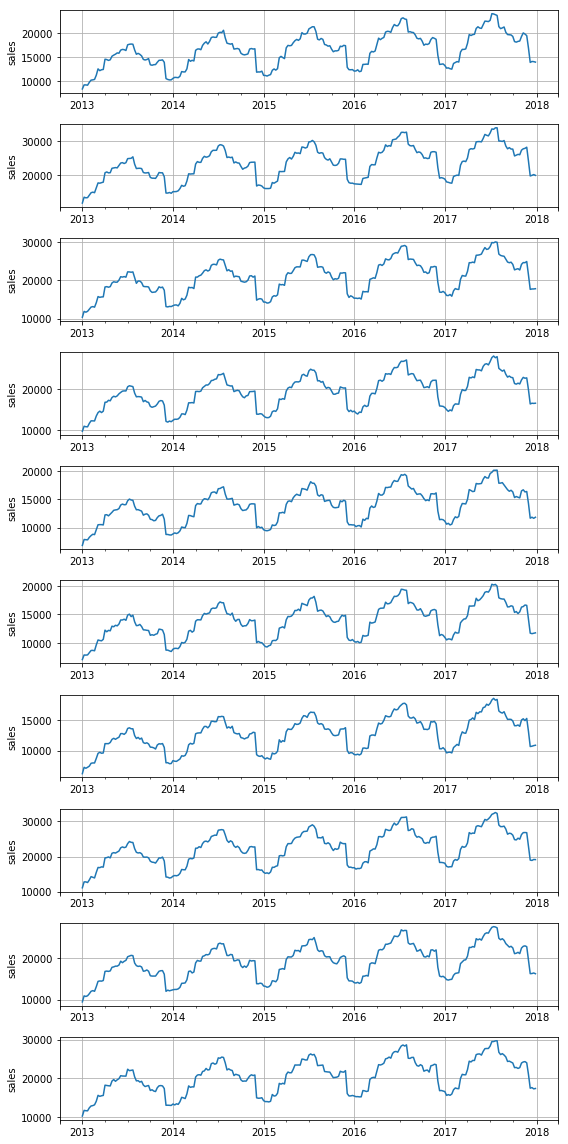

In [64]:
num_stores = len(pd_train['store'].unique())
fig, axes = plt.subplots(num_stores, figsize=(8, 16))

for s in pd_train['store'].unique():
    t = pd_train.loc[pd_train['store'] == s, 'sales'].resample('W').sum()
    ax = t.plot(ax=axes[s-1])
    ax.grid()
    ax.set_xlabel('')
    ax.set_ylabel('sales')
fig.tight_layout();

In [65]:
proph_results = pd_test.reset_index()
proph_results['sales'] = 0

In [66]:
tic = time.time()

for s in proph_results['store'].unique():
    print("s",s)
    for i in proph_results['item'].unique():
        #print("i",i)
        proph_train = pd_train.loc[(pd_train['store'] == s) & (pd_train['item'] == i)].reset_index()
        #print("proph_train",proph_train)
        proph_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        #print("proph_train",proph_train)
        #print(list(proph_train))
        m = Prophet()
        m.fit(proph_train[['ds', 'y']])
        future = m.make_future_dataframe(periods=len(pd_test.index.unique()), include_history=False)
        fcst = m.predict(future)
        proph_results.loc[(proph_results['store'] == s) & (proph_results['item'] == i), 'sales'] = fcst['yhat'].values
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}s".format(s, i, toc-tic))

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


s 1


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 1 item 10. Cumulative time: 21.4s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 1 item 20. Cumulative time: 42.7s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 1 item 30. Cumulative time: 64.2s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 1 item 40. Cumulative time: 86.1s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 1 item 50. Cumulative time: 108.8s
s 2


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 2 item 10. Cumulative time: 131.0s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 2 item 20. Cumulative time: 154.0s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 2 item 30. Cumulative time: 176.6s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 2 item 40. Cumulative time: 199.2s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 2 item 50. Cumulative time: 221.0s
s 3


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 3 item 10. Cumulative time: 243.1s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 3 item 20. Cumulative time: 265.4s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 3 item 30. Cumulative time: 287.7s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 3 item 40. Cumulative time: 308.9s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 3 item 50. Cumulative time: 331.2s
s 4


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 4 item 10. Cumulative time: 353.1s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 4 item 20. Cumulative time: 375.7s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 4 item 30. Cumulative time: 397.2s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 4 item 40. Cumulative time: 419.3s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 4 item 50. Cumulative time: 440.8s
s 5


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 5 item 10. Cumulative time: 462.6s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 5 item 20. Cumulative time: 484.6s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 5 item 30. Cumulative time: 506.4s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 5 item 40. Cumulative time: 527.8s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 5 item 50. Cumulative time: 549.9s
s 6


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 6 item 10. Cumulative time: 571.5s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 6 item 20. Cumulative time: 592.9s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 6 item 30. Cumulative time: 615.0s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 6 item 40. Cumulative time: 636.9s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 6 item 50. Cumulative time: 657.8s
s 7


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 7 item 10. Cumulative time: 679.8s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 7 item 20. Cumulative time: 701.3s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 7 item 30. Cumulative time: 722.9s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 7 item 40. Cumulative time: 745.6s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 7 item 50. Cumulative time: 767.4s
s 8


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 8 item 10. Cumulative time: 789.5s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 8 item 20. Cumulative time: 812.1s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 8 item 30. Cumulative time: 834.8s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 8 item 40. Cumulative time: 857.1s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 8 item 50. Cumulative time: 878.3s
s 9


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 9 item 10. Cumulative time: 900.5s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 9 item 20. Cumulative time: 922.4s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 9 item 30. Cumulative time: 944.7s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 9 item 40. Cumulative time: 967.6s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 9 item 50. Cumulative time: 990.3s
s 10


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 10 item 10. Cumulative time: 1011.5s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 10 item 20. Cumulative time: 1034.3s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 10 item 30. Cumulative time: 1057.2s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 10 item 40. Cumulative time: 1079.4s


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

Completed store 10 item 50. Cumulative time: 1101.8s


# prohpet2

In [67]:
#from fbprophet import Prophet
df_raw = pd.read_csv('train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])

date_sales = df_raw.drop(['store','item'], axis=1).copy()

df_raw = df_raw.reset_index()

import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'date',False)


df_raw['sales'] = df_raw['sales'] * 1.0


In [68]:
#print(list(df))
df = date_sales.reset_index()
#print(list(df))
df.columns = ['ds', 'y']
#df.head()


In [69]:
df['store'] = df_raw['store'].copy()
df['Week'] = df_raw['Week'].copy()
df['item'] = df_raw['item'].copy()

In [70]:
df = df.query('item == 1 & store == 1')

In [71]:
df.groupby(['Week','store','item'])['y'].mean().reset_index().head(10)

,Week,store,item,y
0,1,1,1,13.970588
1,2,1,1,13.200000
2,3,1,1,14.114286
3,4,1,1,13.828571
4,5,1,1,14.342857
5,6,1,1,14.114286
6,7,1,1,15.228571
7,8,1,1,14.371429
8,9,1,1,15.342857
9,10,1,1,15.771429


In [72]:
prediction_size = 31 
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y,store,Week,item
1792,2017-11-28,14,1,48,1
1793,2017-11-29,28,1,48,1
1794,2017-11-30,15,1,48,1


In [73]:
%%time
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds','y']]);

CPU times: user 567 ms, sys: 1.94 ms, total: 569 ms
Wall time: 567 ms


In [74]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)




,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [75]:
%%time
forecast = m.predict(future)
forecast.tail(n=3)

CPU times: user 26.9 s, sys: 5.14 s, total: 32 s
Wall time: 6.38 s


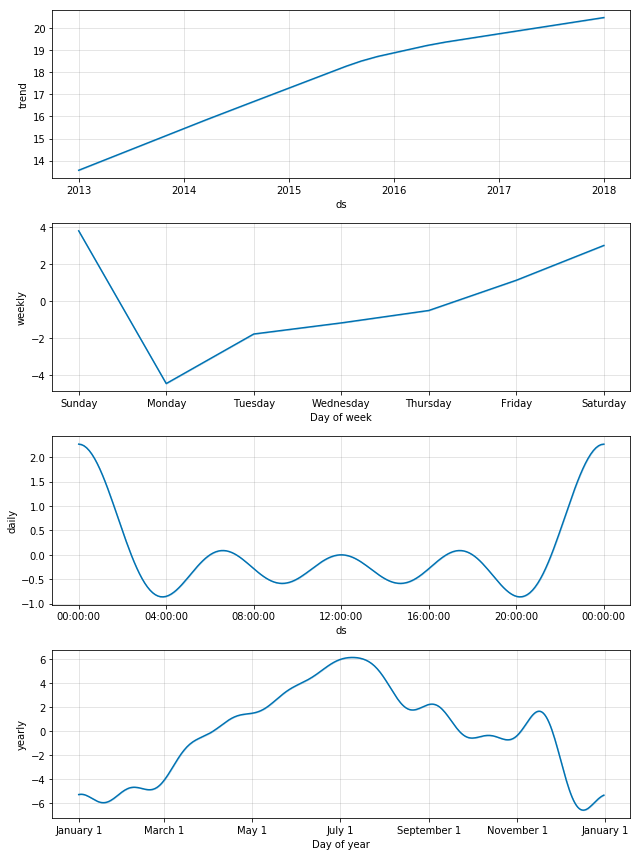

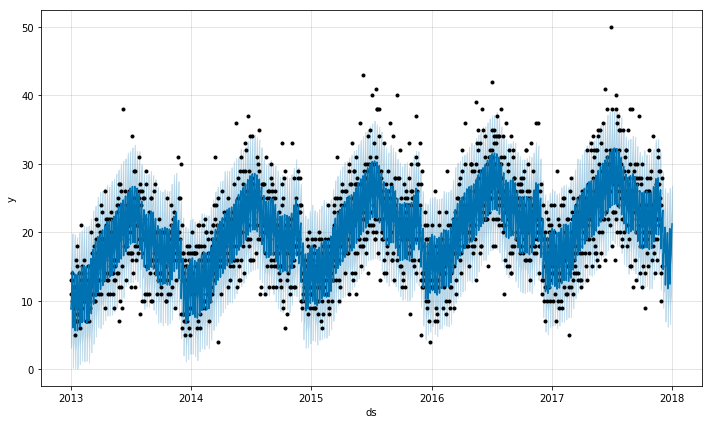

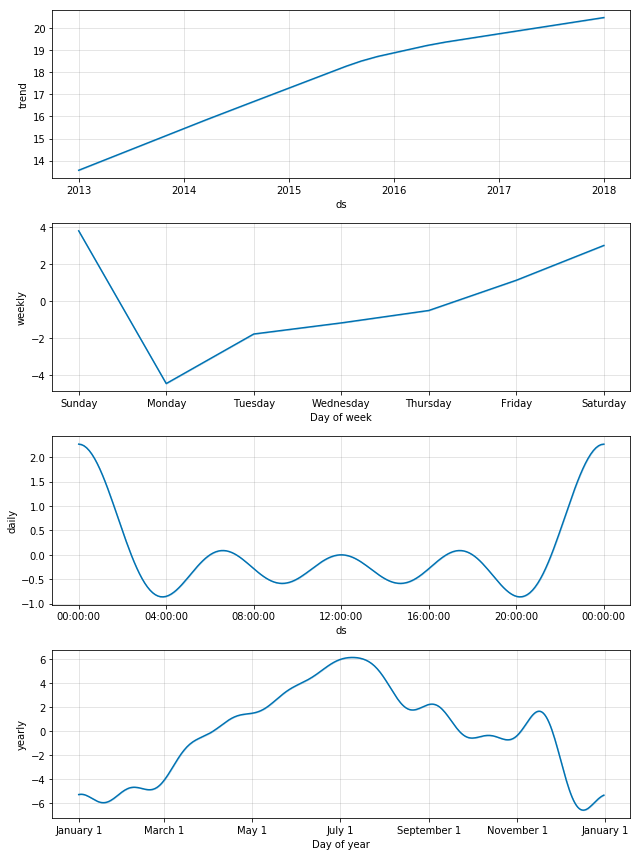

In [76]:
m.plot(forecast)
m.plot_components(forecast)

In [77]:
#adding holidays
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))

In [78]:
%%time
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(train_df[['ds','y']]);

CPU times: user 544 ms, sys: 926 µs, total: 545 ms
Wall time: 544 ms


In [79]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [80]:
%%time
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

CPU times: user 34.5 s, sys: 6.43 s, total: 40.9 s
Wall time: 7.98 s


In [81]:
#from the docs..
forecast_holi[(forecast_holi['playoff'] + forecast_holi['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
1777,2017-11-13,0.000000,0.680987
1787,2017-11-23,0.000000,-0.513093
1788,2017-11-24,0.000000,0.017288
1789,2017-11-25,0.000000,-0.694799
1790,2017-11-26,0.000000,0.680987
1818,2017-12-24,-0.265962,0.000000
1819,2017-12-25,-1.268090,-0.513093
1820,2017-12-26,1.108504,0.017288
1821,2017-12-27,0.000000,-0.694799
1822,2017-12-28,0.000000,0.680987


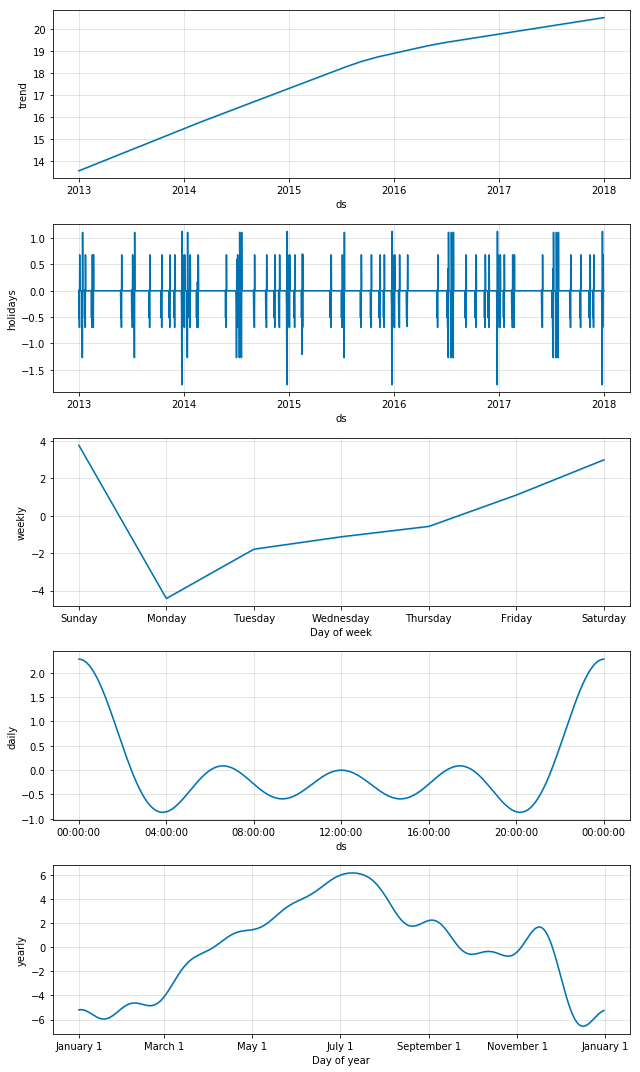

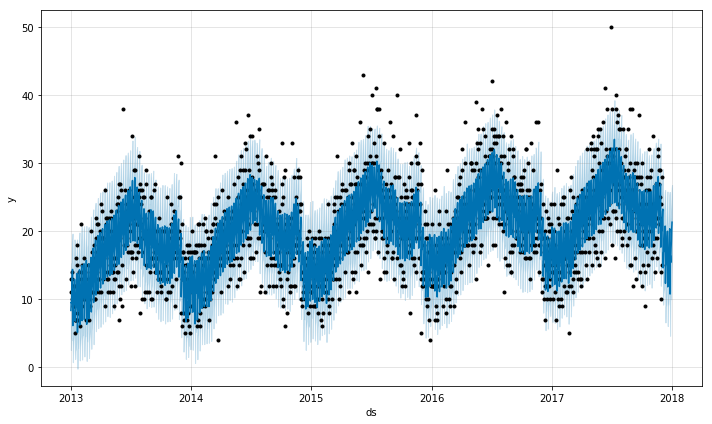

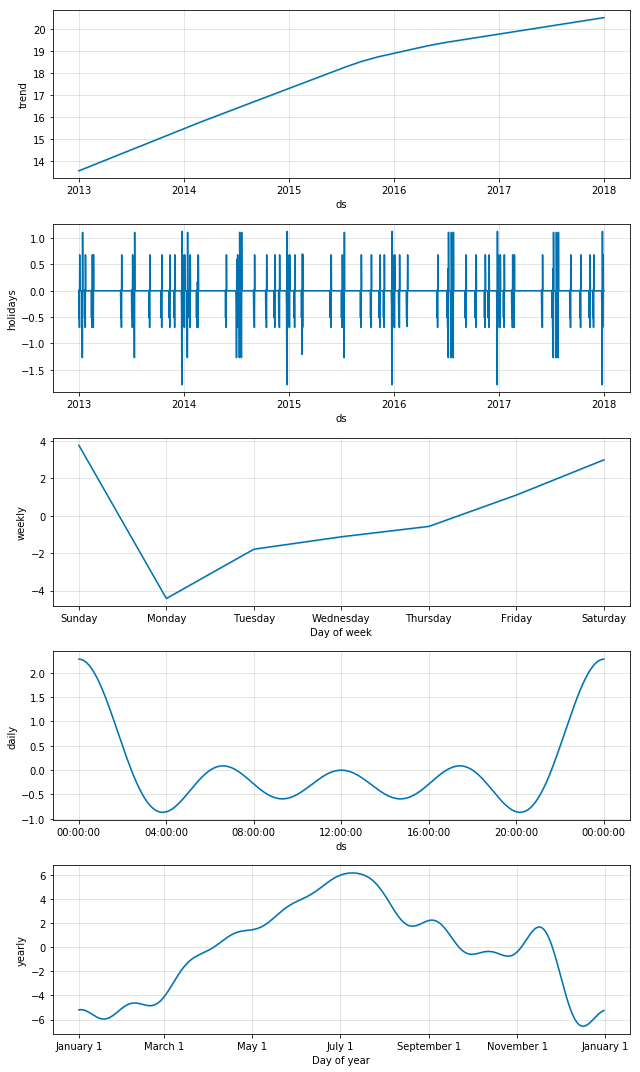

In [82]:
m_holi.plot(forecast_holi)
m_holi.plot_components(forecast_holi)

In [83]:
print(', '.join(forecast.columns))

ds, trend, trend_lower, trend_upper, yhat_lower, yhat_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, yhat


In [84]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [85]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(3)

,yhat,yhat_lower,yhat_upper,y,store,Week,item
ds,,,,,,,
2017-12-29,18.422304,12.596602,23.418414,15,1,52,1
2017-12-30,20.372382,14.629724,25.607502,27,1,52,1
2017-12-31,21.220831,15.823549,26.803571,23,1,52,1


In [86]:
cmp_df_holi = make_comparison_dataframe(df, forecast_holi)
cmp_df_holi.tail(3)

,yhat,yhat_lower,yhat_upper,y,store,Week,item
ds,,,,,,,
2017-12-29,18.515615,13.079207,24.174364,15,1,52,1
2017-12-30,20.476376,15.006880,26.331905,27,1,52,1
2017-12-31,21.318202,15.754224,26.792620,23,1,52,1


In [87]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [88]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)

Non Holiday MAE 3.546839018760929
Non Holiday MAPE 27.483614502454824


In [89]:
for err_name, err_value in calculate_forecast_errors(cmp_df_holi, prediction_size).items():
    print('Including Holiday', err_name, err_value)

Including Holiday MAE 3.5418793156816846
Including Holiday MAPE 27.604860045997174


In [90]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'Sales on Store $1$ for Item $1$')


In [91]:
show_forecast(cmp_df_holi, prediction_size, 100, 'Sales on Store $1$ for Item $1$ Holidays Version')


# prophet3 - With Box Cox Transformation

In [92]:
from scipy import stats
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)
#train_df2 = df.copy().set_index('ds')
train_df2 = df[:-prediction_size]

In [93]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [94]:
m2 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m2.fit(train_df2[['ds','y']]);

CPU times: user 395 ms, sys: 2.93 ms, total: 398 ms
Wall time: 395 ms


In [95]:
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

In [97]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [98]:
cmp_df2 = make_comparison_dataframe(df, forecast2)

,yhat,yhat_lower,yhat_upper,y,store,Week,item
ds,,,,,,,
2017-12-27,15.454629,10.582687,20.857234,14,1,52,1
2017-12-28,16.164782,11.251285,22.016820,19,1,52,1
2017-12-29,17.769693,12.746490,23.637033,15,1,52,1
2017-12-30,19.530139,14.187160,25.015987,27,1,52,1
2017-12-31,20.390479,15.071230,26.383449,23,1,52,1


In [99]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print('Prophet prediction', err_name, err_value)

Including Holidays MAE 3.4907294935131095
Including Holidays MAPE 26.269034503369813


In [ ]:
#actual prediction on submission set

future3 = m2.make_future_dataframe(periods=len(pd_test), include_history=False)
fcst_prophet = m.predict(future3)

In [100]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'With Box–Cox transformation')

In [101]:
y = date_sales['sales'].resample('D').mean() #W
y=y.loc['2015-01-01':]


In [102]:
import itertools

y = date_sales['sales'].resample('D').mean() #W
y=y.loc['2014-01-01':]


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


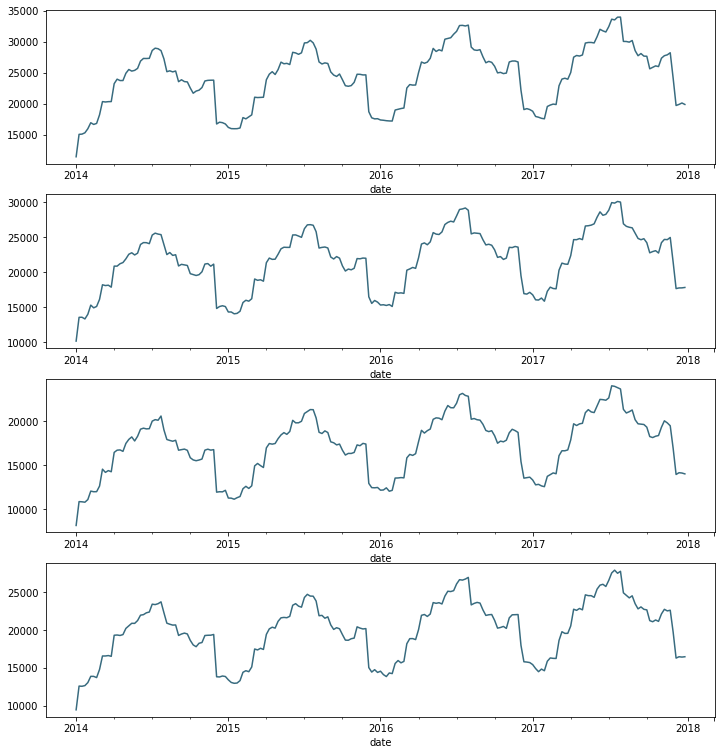

In [103]:
#### Seasonality Check
# preparation: input should be float type
df_raw = pd.read_csv('train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])
df_raw['sales'] = df_raw['sales'] * 1.0
df_raw = df_raw.loc['2014-01-01':]
# store types
sales_a = df_raw[df_raw.store == 2]['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.store == 3]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df_raw[df_raw.store == 1]['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.store == 4]['sales'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
c = '#386B7F'

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



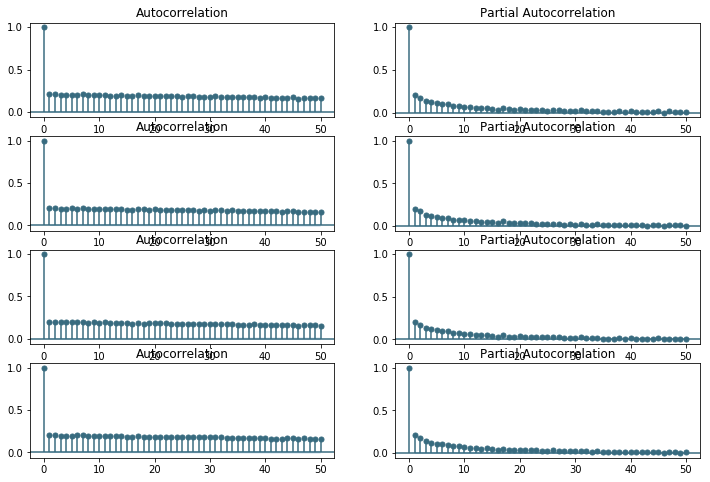

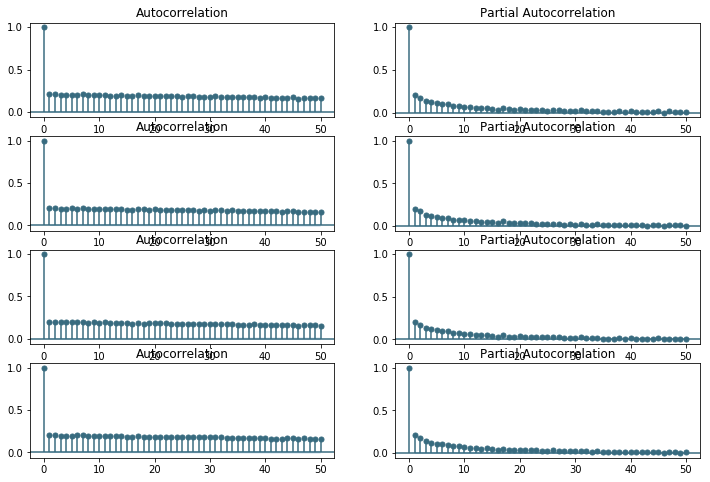

In [104]:
# figure for subplots
plt.figure(figsize = (12, 8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)
#these plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

In [105]:
#for param in pdq:
#    for param_seasonal in seasonal_pdq:
#        try:
#            mod = sm.tsa.statespace.SARIMAX(y,
#                                            order=param,
#                                            seasonal_order=param_seasonal,
#                                            enforce_stationarity=False,
#                                            enforce_invertibility=False)
#            results = mod.fit()
#            cnt += 1
#            if cnt % 50 :
#                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
#        except:
#            continue

In [106]:
import statsmodels.api as sm

In [107]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 1),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5818      0.045    -12.887      0.000      -0.670      -0.493
ar.L2         -0.1724      0.036     -4.819      0.000      -0.242      -0.102
ma.L1          1.0000      3.268      0.306      0.760      -5.405       7.405
ar.S.L12      -0.6848      0.027    -25.120      0.000      -0.738      -0.631
ar.S.L24      -0.5610      0.038    -14.925      0.000      -0.635      -0.487
sigma2       125.4245    409.380      0.306      0.759    -676.945     927.794


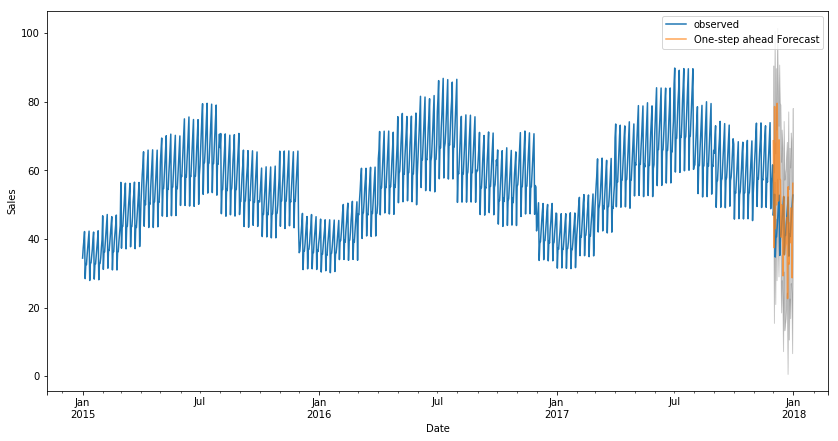

In [108]:
## Validating Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-12-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [109]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#The MSE is a measure of the quality of an estimator — it is always non-negative, 
#and the smaller the MSE, the closer we are to finding the line of best fit.

The Mean Squared Error of our forecasts is nan


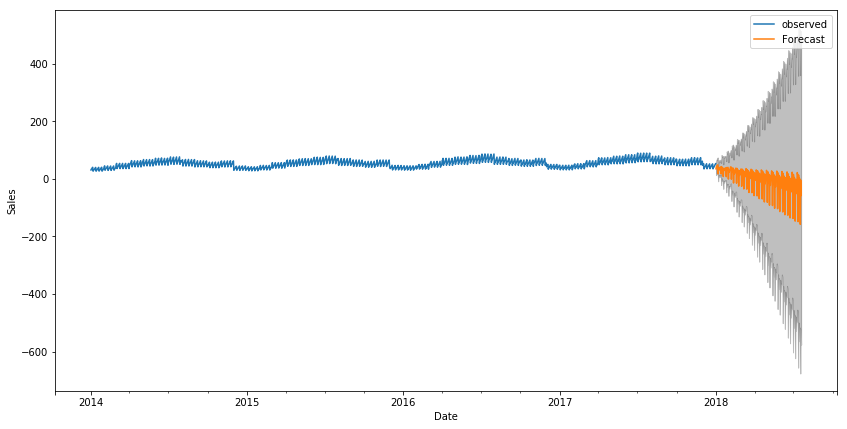

In [110]:
pred_uc = results.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [111]:
pred2 = results.get_prediction()
pred_ci2 = pred2.conf_int()

y_forecasted2 = pred2.predicted_mean


pred_uc2 = results.get_forecast(steps=100)
pred_ci = pred_uc2.conf_int()

In [112]:
pred_ci[1:20]

,lower sales,upper sales
2018-01-02,19.510211,67.098991
2018-01-03,15.852665,66.816174
2018-01-04,20.824907,72.330193
2018-01-05,23.202870,74.721937
2018-01-06,-8.218591,43.303866
2018-01-07,14.200278,65.725664
2018-01-08,9.674831,61.200677
2018-01-09,5.668415,57.194270
2018-01-10,9.064210,60.590069
2018-01-11,14.370660,65.896521
